In [ ]:
%pylab inline
import warnings
import pandas as pd
warnings.filterwarnings('ignore')
#import rpy2.robjects as robjects
#from rpy2.robjects import r, pandas2ri
#pandas2ri.activate()
#from rpy2.robjects.packages import importr, data
from sklearn import preprocessing

In [ ]:
cd /Share/home/chenxupeng/projects/math/

In [ ]:
data = pd.read_csv('L3_1_DVA_FIN.csv')
print data.shape
data.columns

In [ ]:
print 'column number: %s' %(str(48*48*35))
print 'row number: %s' %(str(48*35))

In [ ]:
data['Unnamed: 0']

In [ ]:
data.columns[31:61]

In [ ]:
#查看稀疏矩阵的数据特征，发现其严格对角线排布
arrdata = np.array(data.iloc[:,1:])
arrdata[arrdata !=0] = 1
fig,ax = plt.subplots(4,4,figsize = (120,40))
for i in range(4):
    for j in range(4):
        ax[i,j].matshow(arrdata[:,5040*(i*4+j):5040*(i*4+j+1)])
#savefig('arrdata.png')

In [ ]:
arrdata = np.array(data.iloc[:,1:])
print arrdata.shape

## 先检验数据结构是否符合国家对应的规律，再转换矩阵重新存储
另需确定命名规则是否规律  并存储国家名
sparse to dense
check for loop result

### 先check 商品数字是否始终保持c1-c35

In [463]:
colname = np.ndarray([80640,3]).astype('str')
for i in range(80640):
    colname[i] = data.columns[1:][i].split('.')
rowname = np.ndarray([1680,2]).astype('str')
for j in range(1680):
    rowname[j] = data['Unnamed: 0'][j].split('.')
rowlist = []
for i in range(1680):
    rowlist.append(float(rowname[:,1][i][1:]))
collist = []
for i in range(80640):
    collist.append(float(colname[:,1][i][1:]))

(array([  2303.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  78336.]),
 array([-34. , -30.5, -27. , -23.5, -20. , -16.5, -13. ,  -9.5,  -6. ,
         -2.5,   1. ]),
 <a list of 10 Patch objects>)

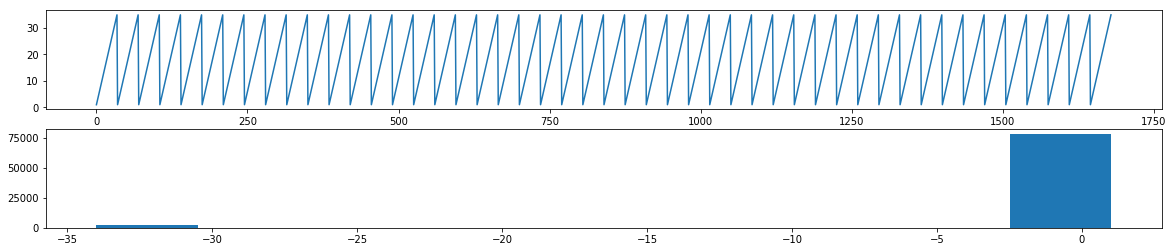

In [401]:
fig,ax = plt.subplots(2,figsize=(20,4))
ax[0].plot(rowlist)
ax[1].hist(np.array(collist[1:]) - np.array(collist[:-1]),bins = 10)
#figure1证明每行的c*按顺序排列 figure2证明每列的c*也按顺序依次排列

In [ ]:
print np.unique(np.array(collist[1:]) - np.array(collist[:-1]))
fig,ax = plt.subplots(12,4,figsize=(40,24))
for i in range(12):
    for j in range(4):
        ax[i,j].plot(collist[1680*(4*i+j):1680*(4*i+j+1)])
#也是为了证明了每列c*都是按顺序来的  错位做差只有两种值也可以用来证明

### check国家名称对应

In [ ]:
#使用encoder方式编码国家名，再可视化以便确定国家的对应关系是否符合规律
#注意unique返回结果必须要求按照原array中顺序，不可以按照字母表顺序
#sklearn encoder使用有问题，自定义counencoder将str转化为数字
_, idx = np.unique(rowname[:,0], return_index=True)
unicout =  rowname[:,0][np.sort(idx)]
#le = preprocessing.LabelEncoder() 
#le.fit(unicout)

In [ ]:
def counencoder(arr):
    for i in range(48):
        arr[np.where(arr==unicout[i])[0]] =i
    return arr.astype('float')

rowcountry = le.transform(rowname[:,0])
#此法经画图还是有问题，不用了
fig,ax = plt.subplots(2,figsize=(20,6))
ax[0].plot(rowcountry)
ax[1].plot(counencoder(rowname[:,0]))
colcountry1 = le.transform(colname[:,0])
colcountry2 = le.transform(colname[:,2])

In [ ]:
rowcountry = counencoder(rowname[:,0])
colcountry1 = counencoder(colname[:,0])
colcountry2 = counencoder(colname[:,2])

In [ ]:
fig,ax = plt.subplots(3,figsize=(20,12))
ax[0].plot(colcountry1.reshape(-1,35)[:,0][:48*35])
ax[0].set_title('col first country name change every 35 blocks (meets expectation)')
ax[1].plot(colcountry2.reshape(-1,35)[:,0][:48*35])
ax[1].set_title('col second country name change every 35 blocks (meets expectation)')
ax[2].plot(rowcountry)
ax[2].set_title('row country name change each block (meets expectation with pic2 )')

### 经过调整encoder规则和unique不要按字母表顺序，可以看到命名规则相当完美，符合预测

## check完成，转换为dense 4d tensor并且用HDF5格式存储

### 矩阵转tensor规则
unicout densearr  #dense中的[A,B],第一个国家A作为原纵坐标,第二个国家B作为横坐标第一个,总体原横坐标为:B_c*_A,注意横纵坐标指原csv文件中以坐标系角度思考，纵坐标指每行的名字1648个，横坐标指每列名字80640个.在numpyarray中，[i,j]指第i行第j列，即原csv中纵坐标下第i个国家，横坐标下国家一中的第j个国家，国家二中的第i个国家。已经验证过该数据整理规则，c*符合规则，对角关系，国家排列，横坐标第二国家和纵坐标国家也存在对应，对应国家才有值，因此最终将sparse矩阵1680*80640转化为48*48*35*35，压缩48倍

In [ ]:
import h5py
#用HDF5存储，节约存储空间

In [ ]:
densearr= np.ndarray([48,48,35,35])
for i in range(48):
    for j in range(48):
        densearr[i,j] = arrdata[35*i:35*(i+1),j*35*48+35*i:j*35*48+35*(i+1)]
densearr.shape
densearr[0,1]  #第一个国家A作为横坐标 第二个国家B作为纵坐标第一个 即 A c* B c* A

In [ ]:
notes = np.array(['dense:[A,B,:,:],first country A is original vertical coordinates,second country B\
is horizontal ordinate first country name, the whole original horizontal ordinate \
vertical coordinate refers to 1680 row names and horizontal ordinate refers to 80640 \
col names. In numpy array, [i,j,:,:] refers to ith row and jth col, which is ith country in \
ordinate(country2) in original csv file. the verification of organization rule has been done.\
the sparse to dense conversion is verified. finally the sparse matrix with shape 1680*80640 is converted \
to tensor with shape 48*48*35*35,compression rate 48 fold'])

### 存储tensor至HDF5

In [514]:
with h5py.File('densearrayL3_1_DVA_FIN.h5') as f:
    f.create_dataset('dense',data = densearr)
    f.create_dataset('country',data = unicout)
    f.create_dataset('notes',data = notes)

### 重新读取文件，导出格式为numpy array

In [515]:
with h5py.File('densearrayL3_1_DVA_FIN.h5') as f:
    print f.keys()

[u'country', u'dense', u'notes']


In [516]:
with h5py.File('densearrayL3_1_DVA_FIN.h5') as f:
    densearray = f['dense'][:]
    country = f['country'][:]
    notes = f['notes'][:]
densearray.shape

(48, 48, 35, 35)

In [517]:
country

array(['AUS', 'AUT', 'BEL', 'BGR', 'BRA', 'CAN', 'PRC', 'CYP', 'CZE',
       'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN',
       'IDN', 'IND', 'IRL', 'ITA', 'JPN', 'KOR', 'LTU', 'LUX', 'LVA',
       'MEX', 'MLT', 'NLD', 'POL', 'PRT', 'ROM', 'RUS', 'SVK', 'SVN',
       'SWE', 'TUR', 'TAP', 'USA', 'BAN', 'MAL', 'PHI', 'THA', 'VIE',
       'MON', 'SRI', 'RoW'], 
      dtype='|S32')

In [518]:
notes

array([ 'dense:[A,B,:,:],first country A is original vertical coordinates,second country Bis horizontal ordinate first country name, the whole original horizontal ordinate vertical coordinate refers to 1680 row names and horizontal ordinate refers to 80640 col names. In numpy array, [i,j,:,:] refers to ith row and jth col, which is ith country in ordinate(country2) in original csv file. the verification of organization rule has been done.the sparse to dense conversion is verified. finally the sparse matrix with shape 1680*80640 is converted to tensor with shape 48*48*35*35,compression rate 48 fold'], 
      dtype='|S595')

###  查看任意两个国家的商品关系矩阵，最好做scale

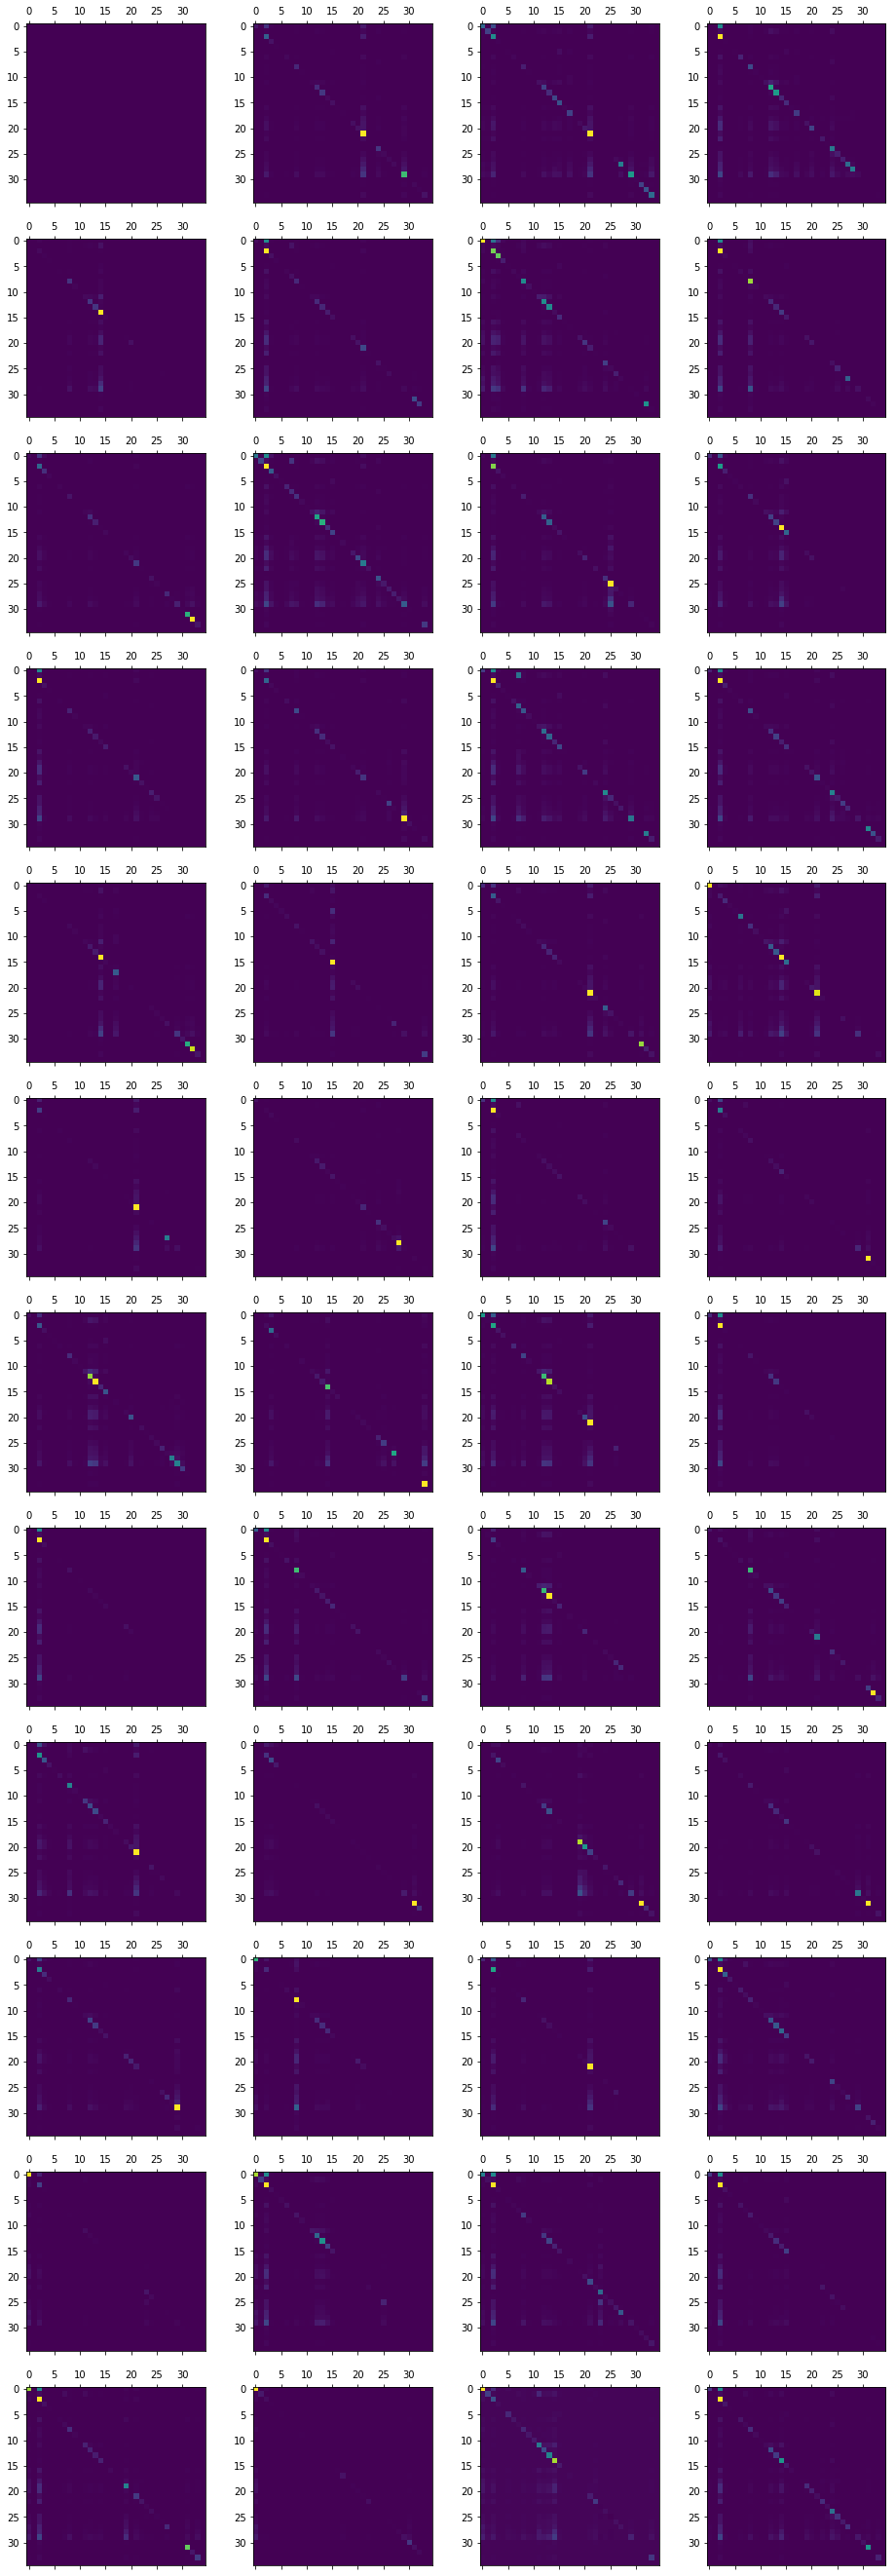

In [521]:
fig,ax = plt.subplots(12,4,figsize=(16,48))
for i in range(12):
    for j in range(4):
        ax[i,j].matshow(densearr[0,4*i+j])

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

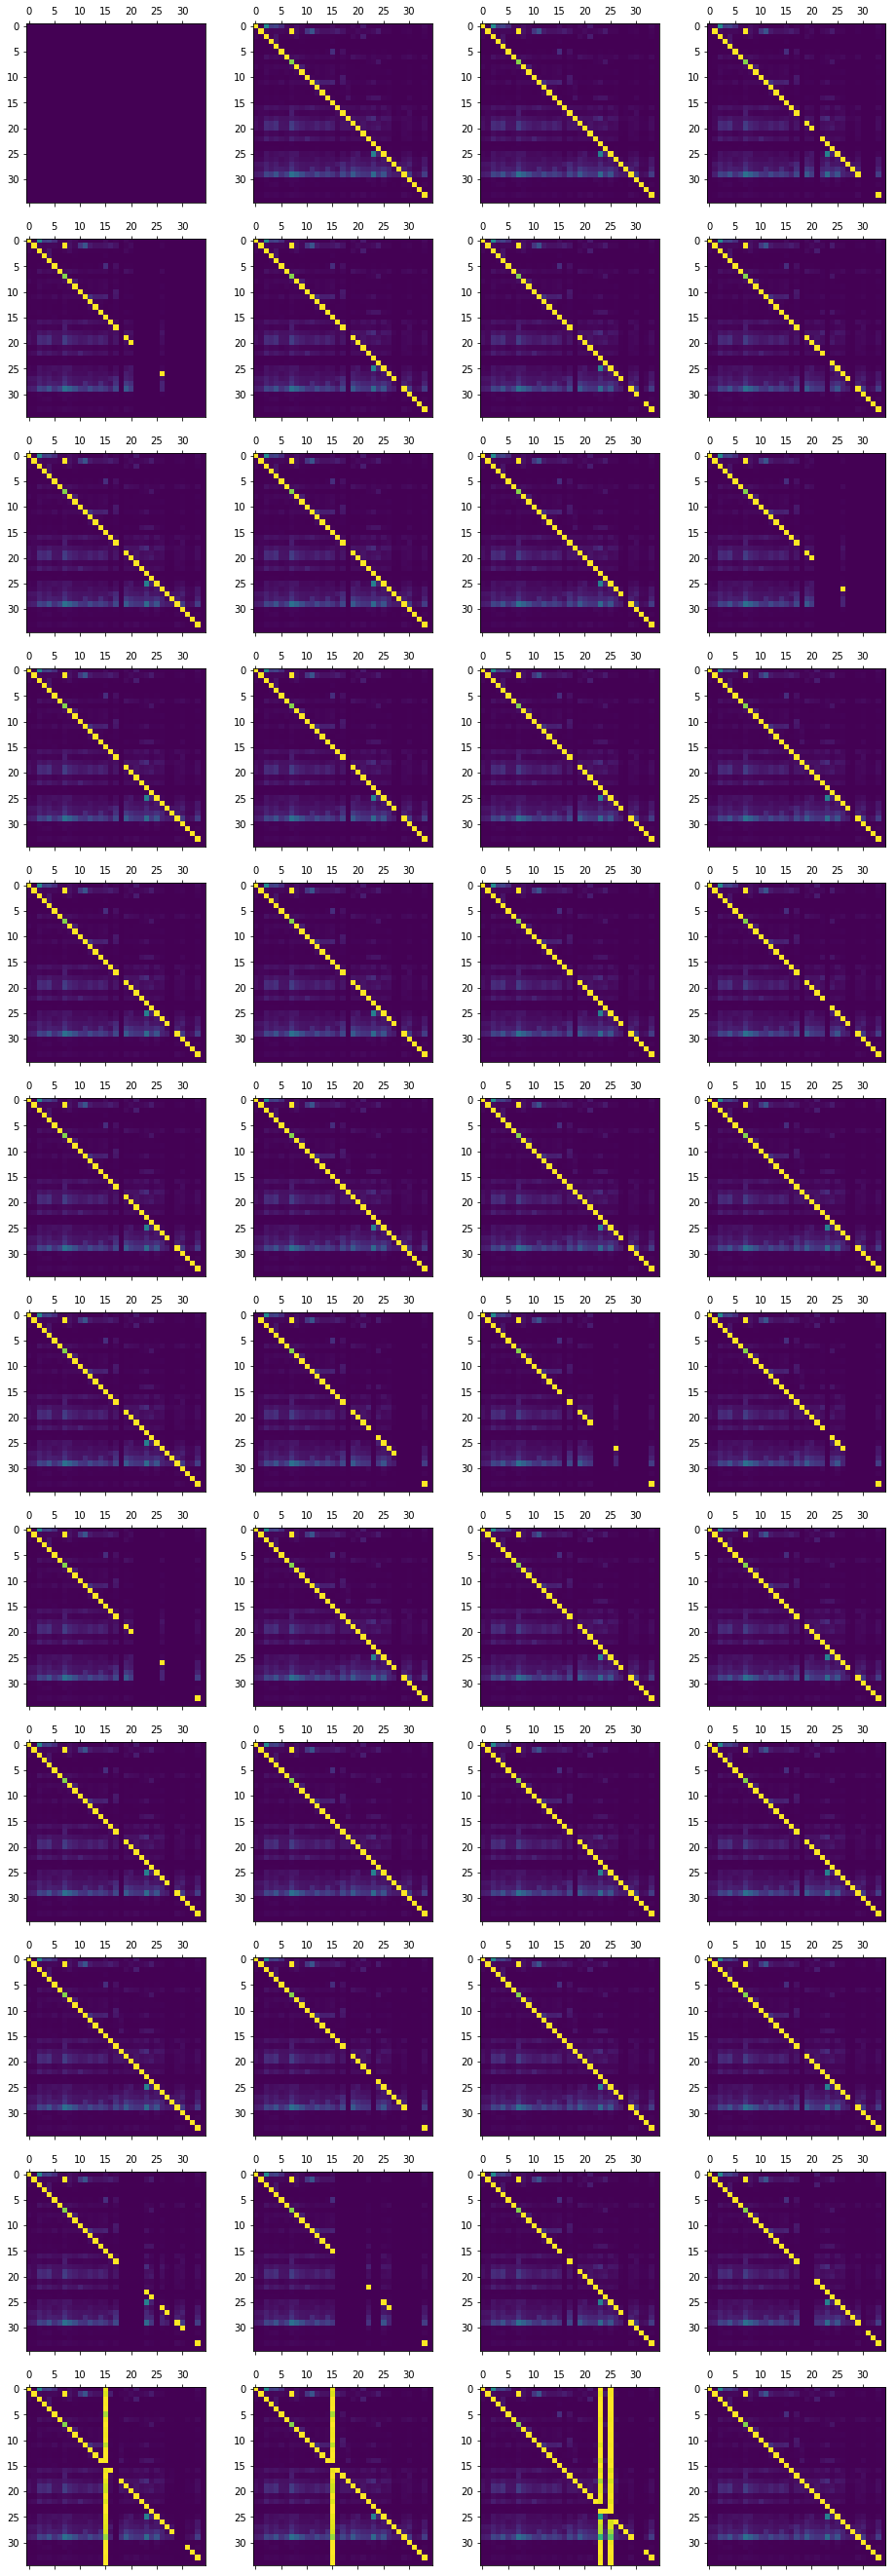

In [524]:
fig,ax = plt.subplots(12,4,figsize=(16,48))
for i in range(12):
    for j in range(4):
        ax[i,j].matshow(scaler.fit_transform(densearr[0,4*i+j]))